In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class tictactoe :
    def __init__(self):
        self.board=torch.zeros([3,3],dtype=torch.int8)
        self.current_player = 1
        self.current_turn= 0
        self.gameover=False

    def view_board(self):
        print(self.board)
        
    def check_win(self, row_in , col_in):

        def checking (current):
            if (torch.all(current==1).item() ):
                self.gameover=True
                return 1.0
            elif(torch.all(current==2).item()):
                self.gameover=True
                return 2.0
            return False  


        col=self.board[:,col_in]
        row=self.board[row_in, :]
        result=checking(row)
        if result:
            return result
        result=checking(col)
        if result:
            return result
        
        if row_in == col_in:
            diag1 = torch.diag(self.board)
            result = checking(diag1)
            if result:
                return result

        if row_in + col_in == self.board.size(0) - 1:
            diag2 = torch.diag(torch.fliplr(self.board))
            result = checking(diag2)
            if result:
                return result
        if(self.current_turn ==9) :
            self.gameover=True
            
        return 0.0
        


    def next_move(self,row,col):
        if (self.gameover==False):
            if not(0 <= row <= 2 and 0 <= col <= 2):
                print("Move is outside the board (must be between 0 and 2).")
                return False
            elif (self.board[row][col]!=0 ):
                print("move is invalid")
                return False
            else:
                self.board[row][col]=self.current_player
                self.current_turn +=1
                self.current_player +=1
                if (self.current_player==3) :
                    self.current_player=1
                return self.check_win(row,col)

        else:
            print("Game is over no more turns possible")
    def bot_move(self):
        random_move=np.random.randint(low=0,high=9-self.current_turn)
        free_slots=torch.nonzero(self.board==0)
        i=free_slots[random_move][0]
        j=free_slots[random_move][1]
        return self.next_move(i,j)
    

    def get_possible_actions(self, board):
        free_slots=torch.nonzero(board==0).tolist()
        return [tuple(row) for row in free_slots]
    

    def player_move(self):
        r=int(input("row"))
        c=int(input("col"))
        return self.next_move(r,c)

    
    def play_game(self):
        random_start=np.random.randint(low=0,high=2)==0

        if (random_start==0):
            print("Bot starts first")
            self.bot_move()
        else:
            print("player starts first")
            self.player_move()
        self.view_board()

        while(not(self.gameover)):
            if (random_start==0):
                self.player_move()
                self.bot_move()
            if (random_start==1):
                self.bot_move()
                self.player_move()
            self.view_board()
    
    def get_state_key(self,board):
        array=board.flatten().numpy()
        return "".join(map(str,array))                      
    def reset_game(self):
        self.board=torch.zeros([3,3],dtype=torch.int8)
        self.current_player=1
        self.current_turn=0
        self.gameover=False
    def get_canonical_key(self,board):
        
        all_states={}
        all_states[self.get_state_key(board)]="00"

        for i in range (1,4):
            rotated_board=torch.rot90(board ,k=i)
            all_states[self.get_state_key(rotated_board)]="0"+str(i)

        all_states[self.get_state_key(torch.fliplr(board))]="10"    

        for i in range (1,4):
            rotated_board=torch.rot90(torch.fliplr(board),k=i)
            all_states[self.get_state_key(rotated_board)]="1"+str(i)

        canon_key = sorted(all_states)[0]
        transform=all_states[canon_key]
        return canon_key , transform



    def inverse_action(self, action, transform):
        def mirror(action):
            if action[1]==1:
                return action
            elif action[1]==0:
                return (action[0],2)
            elif action[1]==2:
                return (action[0],0)
        k=int(transform[1])

        if action==(1,1) :
            return action
        corner=[(0,0),(2,0),(2,2),(0,2)]
        side=[(0,1),(1,0),(2,1),(1,2)]
        if action in corner :
            index=corner.index(action)
            new_index=(index-k)%len(corner)
            action= corner[new_index]
        else :
            index=side.index(action)
            new_index=(index-k)%len(side)
            action= side[new_index]
        if transform[0]=="1":
            action=mirror(action)
        return action


        
    def key_state_to_board(self,key_state):
        counter=0
        board=torch.zeros(3,3, dtype=torch.int8)
        for i in range (3):
            for j in range (3):
                board[i][j]=int(key_state[counter])
                counter +=1
        return board
        


In [52]:
class Agent:
    def __init__(self):
        self.alpha=0.2
        self.gamma=0.95
        self.epsilon=0.3
        self.epsilon_decay_rate = 0.99995
        self.epsilon_min = 0.0000000001
        self.q_table={} 
    def choose_action(self,state_key,possible_actions):
        explore=np.random.choice([1,0],p=[self.epsilon,1-self.epsilon])
        if explore :
            return random.choice(possible_actions)
        else :
            if state_key not in self.q_table:
                return random.choice(possible_actions)
            else:
                best_score=-999
                best_action=None
                action_scores=self.q_table[state_key]
                for action in possible_actions:
                    result=action_scores.get(action,0.0)
                    if best_score<result:
                        best_score=result
                        best_action=action
                return best_action    
    def update_q_table(self, state_key, action, reward, next_state_key, next_possible_actions):
        if state_key not in self.q_table:
            self.q_table[state_key]={}

        old_q_value=self.q_table[state_key].get(action, 0.0)
        best_future_score=0.0
        if next_possible_actions:

            if next_state_key in self.q_table:

                action_scores = self.q_table[next_state_key]
                scores = [action_scores.get(a, 0.0) for a in next_possible_actions]
                best_future_score = max(scores)


        error=reward+self.gamma*best_future_score -old_q_value
        new_q_value=old_q_value+self.alpha*error
        self.q_table[state_key][action]=new_q_value






In [54]:
agent1=Agent()

In [53]:
agent2=Agent()

In [12]:
game1=tictactoe()

Epoch 1000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 2000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 3000/10000 | Win Rate: 0.98 | Loss Rate: 0.00 | Draw Rate: 0.02
Epoch 4000/10000 | Win Rate: 0.98 | Loss Rate: 0.00 | Draw Rate: 0.02
Epoch 5000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 6000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 7000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 8000/10000 | Win Rate: 0.99 | Loss Rate: 0.00 | Draw Rate: 0.01
Epoch 9000/10000 | Win Rate: 0.98 | Loss Rate: 0.01 | Draw Rate: 0.02
Epoch 10000/10000 | Win Rate: 0.98 | Loss Rate: 0.00 | Draw Rate: 0.01
Training complete!


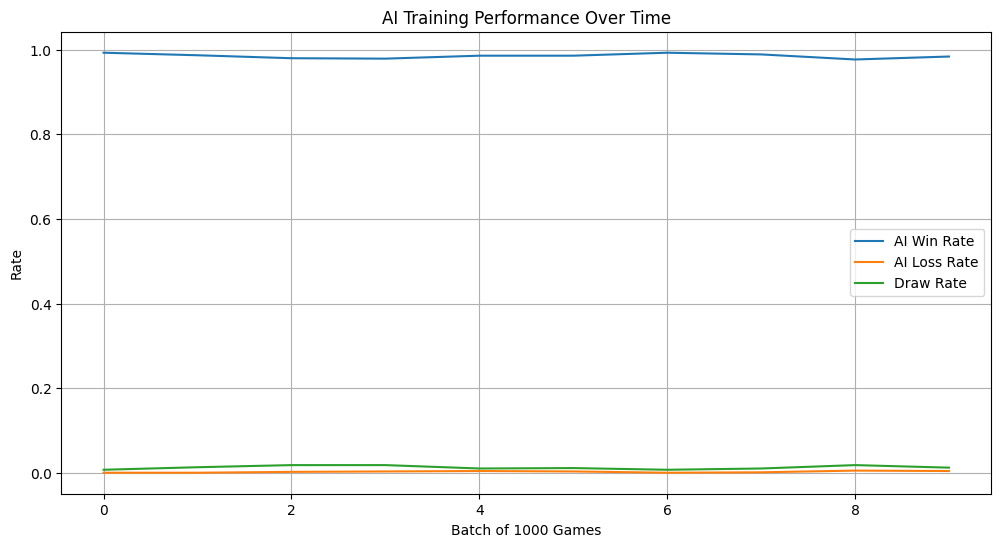

In [62]:
win_log = []
loss_log = []
draw_log = []
total_wins = 0
total_losses = 0
total_draws = 0

num_games = 10000
batch=1000
for epoch in range (num_games):
    game1.reset_game()
    last_agent_s = None
    last_agent_a = None
    current_player=1
    agent2.epsilon = max(agent2.epsilon * agent2.epsilon_decay_rate, agent2.epsilon_min)
    while (not (game1.gameover)):
        
        if current_player==1 :
            canon_state_key , transform =game1.get_canonical_key(game1.board)
            canon_board=game1.key_state_to_board(canon_state_key)
            canon_possible_actions=game1.get_possible_actions(canon_board)


            if last_agent_s is not None:
                agent2.update_q_table(last_agent_s, last_agent_a, 0.0, canon_state_key, canon_possible_actions)
            canon_action=agent2.choose_action(canon_state_key,canon_possible_actions)
            action=game1.inverse_action(canon_action, transform)
            game_flag=game1.next_move(action[0],action[1]) #who won or if draw
            
            canon_next_state_key, next_transform=game1.get_canonical_key(game1.board)
            canon_board=game1.key_state_to_board(canon_next_state_key)
            canon_next_possible_actions=game1.get_possible_actions(canon_board)

            last_agent_s = canon_state_key
            last_agent_a = canon_action


            if (game1.gameover):
                if game_flag == 1.0 : 
                    total_wins += 1 
                    learning_reward = 1.0
                else:
                    total_draws += 1
                    learning_reward = -0.2
                agent2.update_q_table(canon_state_key, canon_action, learning_reward, "", [])
                break
            current_player=2
        else:
            game_flag=game1.bot_move()

            if (game1.gameover):

                if  game_flag== 2.0: 
                    total_losses += 1 
                    learning_reward = -1.0
                else:
                    total_draws += 1
                    learning_reward = -0.2

                if last_agent_s is not None:
                    agent2.update_q_table(last_agent_s, last_agent_a, learning_reward, "", [])
                
                break
            current_player=1

    if (epoch + 1) % batch== 0:
            win_rate = total_wins / batch
            loss_rate = total_losses / batch
            draw_rate = total_draws / batch
            
            win_log.append(win_rate)
            loss_log.append(loss_rate)
            draw_log.append(draw_rate)
            print(f"Epoch {epoch+1}/{num_games} | Win Rate: {win_rate:.2f} | Loss Rate: {loss_rate:.2f} | Draw Rate: {draw_rate:.2f}")
            total_wins = 0
            total_losses = 0
            total_draws = 0

print("Training complete!")
plt.figure(figsize=(12, 6))
plt.plot(win_log, label='AI Win Rate')
plt.plot(loss_log, label='AI Loss Rate')
plt.plot(draw_log, label='Draw Rate')
plt.xlabel(f'Batch of {batch} Games')
plt.ylabel('Rate')
plt.title('AI Training Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()





In [ ]:
num_games = 10000
win_log = []
loss_log = []
draw_log = []
total_wins = 0
total_losses = 0
total_draws = 0
sub_count = 1000
agent2.epsilon = 0.0
for epoch in range(num_games + 1):
    game1.reset_game()
    last_s1_canon, last_a1_canon = None, None
    last_s2_canon, last_a2_canon = None, None

    agent1.epsilon = max(agent1.epsilon * agent1.epsilon_decay_rate, agent1.epsilon_min)
    agent2.epsilon = max(agent2.epsilon * agent2.epsilon_decay_rate, agent2.epsilon_min)

    current_player = 1

    while not game1.gameover:
        if current_player == 1:
            s1_canon, s1_transform = game1.get_canonical_key(game1.board)
            s1_canon_board = game1.key_state_to_board(s1_canon)
            a1_canon_possible = game1.get_possible_actions(s1_canon_board)
            
            a1_canon_chosen = agent1.choose_action(s1_canon, a1_canon_possible)
            
            if last_s1_canon is not None:
                agent1.update_q_table(last_s1_canon, last_a1_canon, 0.0, s1_canon, a1_canon_possible)

            a1_raw_chosen = game1.inverse_action(a1_canon_chosen, s1_transform)

            r1 = game1.next_move(a1_raw_chosen[0], a1_raw_chosen[1])
            
            s1_next_canon, _ = game1.get_canonical_key(game1.board)

            if game1.gameover:
                if r1 == 1.0: 
                    total_wins +=1  
                    agent1.update_q_table(s1_canon, a1_canon_chosen, 1.0, None, [])
                    #if last_s2_canon is not None:
                        #agent2.update_q_table(last_s2_canon, last_a2_canon, -1.0, s1_next_canon, [])
                else:  
                    total_draws +=1
                    agent1.update_q_table(s1_canon, a1_canon_chosen, -0.2,None, [])
                    #if last_s2_canon is not None:
                        #agent2.update_q_table(last_s2_canon, last_a2_canon, 0.0, s1_next_canon, [])
                break
            
            last_s1_canon, last_a1_canon = s1_canon, a1_canon_chosen
            
            current_player = 2 

        else: 
            s2_canon, s2_transform = game1.get_canonical_key(game1.board)
            s2_canon_board = game1.key_state_to_board(s2_canon)
            a2_canon_possible = game1.get_possible_actions(s2_canon_board)

            a2_canon_chosen = agent2.choose_action(s2_canon, a2_canon_possible)

            if last_s2_canon is not None:
                agent2.update_q_table(last_s2_canon, last_a2_canon, 0.0, s2_canon, a2_canon_possible)
            
            a2_raw_chosen = game1.inverse_action(a2_canon_chosen, s2_transform)

            r2 = game1.next_move(a2_raw_chosen[0], a2_raw_chosen[1])
            
            s2_next_canon, _ = game1.get_canonical_key(game1.board)

            if game1.gameover:
                if r2 == 2.0: 
                    total_losses +=1 
                    #agent2.update_q_table(s2_canon, a2_canon_chosen, 1.0, s2_next_canon, [])
                    if last_s1_canon is not None:
                        agent1.update_q_table(last_s1_canon, last_a1_canon, -1.0, None, [])
                else:  
                    total_draws += 1
                    #agent2.update_q_table(s2_canon, a2_canon_chosen, 0.0, s2_next_canon, [])
                    if last_s1_canon is not None:
                        agent1.update_q_table(last_s1_canon, last_a1_canon, -0.2, None, [])
                break

            last_s2_canon, last_a2_canon = s2_canon, a2_canon_chosen

            current_player = 1 
            
    if (epoch + 1) % sub_count == 0:
            win_rate = total_wins / sub_count
            loss_rate = total_losses / sub_count
            draw_rate = total_draws / sub_count
            
            win_log.append(win_rate)
            loss_log.append(loss_rate)
            draw_log.append(draw_rate)
            
            print(f"Epoch {epoch+1}/{num_games} | Win Rate: {win_rate:.2f} | Loss Rate: {loss_rate:.2f} | Draw Rate: {draw_rate:.2f}")
            
            total_wins = 0
            total_losses = 0
            total_draws = 0

print("Training complete!")
plt.figure(figsize=(12, 6))
plt.plot(win_log, label='AI Win Rate')
plt.plot(loss_log, label='AI Loss Rate')
plt.plot(draw_log, label='Draw Rate')
plt.xlabel('Batch of 1000 Games')
plt.ylabel('Rate')
plt.title('AI Training Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1000/10000 | Win Rate: 0.89 | Loss Rate: 0.09 | Draw Rate: 0.03
Epoch 2000/10000 | Win Rate: 0.90 | Loss Rate: 0.08 | Draw Rate: 0.03
Epoch 3000/10000 | Win Rate: 0.91 | Loss Rate: 0.07 | Draw Rate: 0.02
Epoch 4000/10000 | Win Rate: 0.92 | Loss Rate: 0.06 | Draw Rate: 0.02


In [46]:
game2= tictactoe()
agent2.epsilon=0
agent2.alpha=0
while (not (game2.gameover)):
    
    canon_state_key , transform =game2.get_canonical_key(game2.board)
    canon_board=game2.key_state_to_board(canon_state_key)
    canon_possible_actions=game2.get_possible_actions(canon_board)

    canon_action=agent2.choose_action(canon_state_key,canon_possible_actions)
    action=game2.inverse_action(canon_action, transform)
    game_flag=game2.next_move(action[0],action[1]) #who won or if draw
    
    game2.view_board()

    if game2.gameover:
        if game_flag == 2.0:
            print("--- AGENT WINS ---")
        else:
            print("--- GAME IS A DRAW ---")
        break 

    print("\nYour Turn:")
    game_flag = game2.player_move()
    if game2.gameover:
        if game_flag == 1.0:
            print("--- YOU WIN ---")
        else:
            print("--- GAME IS A DRAW ---")
        break
    

game2.view_board()    

tensor([[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int8)

Your Turn:
tensor([[1, 0, 2],
        [0, 0, 0],
        [1, 0, 0]], dtype=torch.int8)

Your Turn:
tensor([[1, 0, 2],
        [2, 0, 0],
        [1, 0, 1]], dtype=torch.int8)

Your Turn:
tensor([[1, 0, 2],
        [2, 2, 0],
        [1, 1, 1]], dtype=torch.int8)
--- GAME IS A DRAW ---
tensor([[1, 0, 2],
        [2, 2, 0],
        [1, 1, 1]], dtype=torch.int8)


In [9]:
# 1) Check learning parameters once before training
game3=tictactoe()
print("alpha, gamma, initial epsilon:", agent1.alpha, agent1.gamma, agent1.epsilon)
action= agent1.choose_action(game3.get_state_key(game3.board), game3.get_possible_actions(game3.board))
# 2) Quick assertion when applying an action (after computing a_raw_chosen, before next_move)
rpos, cpos = action[0], action[1]
assert 0 <= rpos < 3 and 0 <= cpos < 3, "inverse_action returned out-of-range coords"
assert game3.board[rpos][cpos] == 0, f"Trying to play on non-empty cell {rpos,cpos}"

# 3) Log Q value before/after an update (adapt to your q-table structure; example for dict)
key = (last_s1_canon, last_a1_canon)
before = agent1.q_table.get(key, 0) if hasattr(agent1, 'q_table') else None
print("Q before update", key, before)
agent1.update_q_table(last_s1_canon, last_a1_canon, 0.0, s1_canon, a1_canon_possible)
after = agent1.q_table.get(key, 0) if hasattr(agent1, 'q_table') else None
print("Q after update", key, after)


alpha, gamma, initial epsilon: 0.2 0.95 0.3


NameError: name 'last_s1_canon' is not defined